### 批归一化

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.3
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# 导入数据
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all),(x_test, y_test) = fashion_mnist.load_data()
x_vaild, x_train = x_train_all[:5000], x_train_all[5000:]
y_vaild, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_vaild.shape, y_vaild.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# 数据归一化  x = (x - u) / std   u-均值  std-方差  满足 0 1 正态分布
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
# x_train: [None,28, 28] -> [None, 784]
x_train_scalar = scalar.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_vaild_scalar = scalar.fit_transform(x_vaild.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scalar = scalar.fit_transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [4]:
# tf.keras 模型
model = tf.keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    # 批归一化 在激活函数后的实现
    model.add(keras.layers.BatchNormalization())
    """
    # 在激活函数前的实现
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    """
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:

logdir = os.path.join("dnn-bn-callbacks")

if not os.path.exists(logdir):
    os.mkdir(logdir)  
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

In [6]:
history = model.fit(x_train_scalar, y_train, epochs=10,
                    validation_data=(x_vaild_scalar, y_vaild),
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 128us/sample - loss: 1.9604 - accuracy: 0.2399 - val_loss: 1.1373 - val_accuracy: 0.6148
Epoch 2/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.8151 - accuracy: 0.6855 - val_loss: 0.6343 - val_accuracy: 0.7696
Epoch 3/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.5776 - accuracy: 0.7820 - val_loss: 0.5327 - val_accuracy: 0.8028
Epoch 4/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.4983 - accuracy: 0.8201 - val_loss: 0.4657 - val_accuracy: 0.8332
Epoch 5/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.4501 - accuracy: 0.8443 - val_loss: 0.4664 - val_accuracy: 0.8394
Epoch 6/10
55000/55000 [==============================] - 6s 107us/sample - loss: 0.4088 - accuracy: 0.8597 - val_loss: 0.5160 - val_accuracy: 0.8276
Epoch 7/10
55000/55000 [=============================

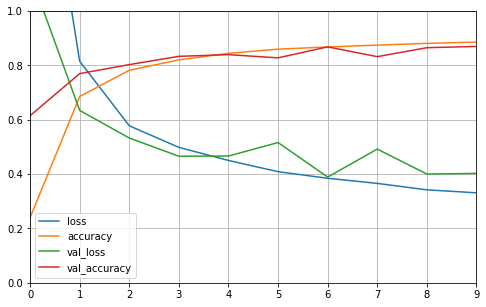

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)

    
    
plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scalar, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4516599181652069, 0.8541]

In [1]:
# 激活函数 selu  -自带归一化的激活函数

1.参数众多，训练不充分  导致学习曲线开始的时候是平直的   
2.梯度消失 -> 链式法则 -> 复合函数f(g(x))   
归一化缓解梯度消失   
selu函数缓解梯度消失   